In [2]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [3]:
#%cd /content/gdrive/My Drive/Kaggle

In [4]:

#!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

In [5]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip 

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from keras import backend as K
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

In [7]:
import os
print(os.listdir("/content/gdrive/My Drive/Kaggle/Coronahack-Chest-XRay-Dataset"))


['Coronahack-Chest-XRay-Dataset']


In [8]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [9]:
print(os.listdir("/content/gdrive/My Drive/Kaggle/corona_check/train/Normal"))
print(os.listdir("/content/gdrive/My Drive/Kaggle/corona_check/test/Normal"))

['IM-0575-0001.jpeg', 'IM-0574-0001.jpeg', 'IM-0571-0001.jpeg', 'IM-0570-0001.jpeg', 'IM-0569-0001.jpeg', 'IM-0568-0001.jpeg', 'IM-0566-0001.jpeg', 'IM-0565-0001.jpeg', 'IM-0564-0001.jpeg', 'IM-0563-0001.jpeg', 'IM-0562-0001.jpeg', 'IM-0561-0001.jpeg', 'IM-0560-0001.jpeg', 'IM-0559-0001.jpeg', 'IM-0557-0001.jpeg', 'IM-0556-0001.jpeg', 'IM-0555-0001.jpeg', 'IM-0555-0001-0002.jpeg', 'IM-0555-0001-0001.jpeg', 'IM-0554-0001.jpeg', 'IM-0553-0001.jpeg', 'IM-0553-0001-0003.jpeg', 'IM-0553-0001-0002.jpeg', 'IM-0553-0001-0001.jpeg', 'IM-0552-0001.jpeg', 'IM-0551-0001.jpeg', 'IM-0551-0001-0002.jpeg', 'IM-0618-0001.jpeg', 'IM-0618-0001-0002.jpeg', 'IM-0618-0001-0001.jpeg', 'IM-0617-0001.jpeg', 'IM-0616-0001.jpeg', 'IM-0615-0001.jpeg', 'IM-0614-0001.jpeg', 'IM-0613-0001.jpeg', 'IM-0612-0001.jpeg', 'IM-0612-0001-0002.jpeg', 'IM-0612-0001-0001.jpeg', 'IM-0609-0001.jpeg', 'IM-0608-0001.jpeg', 'IM-0608-0001-0002.jpeg', 'IM-0608-0001-0001.jpeg', 'IM-0607-0001.jpeg', 'IM-0606-0001.jpeg', 'IM-0605-0001.j

In [10]:
!cd /corona_check/train/
!rm /corona_check/train/*.jpeg

!cd /corona_check/test/
!rm /corona_check/test/*.jpeg

/bin/bash: line 0: cd: /corona_check/train/: No such file or directory
rm: cannot remove '/corona_check/train/*.jpeg': No such file or directory
/bin/bash: line 0: cd: /corona_check/test/: No such file or directory
rm: cannot remove '/corona_check/test/*.jpeg': No such file or directory


In [11]:

import shutil, sys  
def copy_img(src_path,dst_path):
    try:
        shutil.copy(src_path, dst_path)
        stmt ='File Copied'
    except IOError as e:
        print('Unable to copy file {} to {}'
              .format(src_path, dst_path))
        stmt ='Copy Failed - IO Error'
    except:
        print('When try copy file {} to {}, unexpected error: {}'
              .format(src_path, dst_path, sys.exc_info()))
        stmt ='Copy Failed - other Error'+ sys.exc_info()
        
    return stmt 

In [12]:
data_dir="/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
metadata_path="/content/Coronahack-Chest-XRay-Dataset"

In [13]:

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [14]:
meta_data = pd.read_csv("/content/gdrive/My Drive/Kaggle/Chest_xray_Corona_Metadata.csv")
meta_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [15]:
meta_COVID_19_train = meta_data[(meta_data['Dataset_type']=='TRAIN') & 
                        ((meta_data['Label']=='Normal')|(meta_data['Label']=='Pnemonia') & (meta_data['Label_2_Virus_category']=='COVID-19'))]


meta_COVID_19_test = meta_data[(meta_data['Dataset_type']=='TEST') & 
                        ((meta_data['Label']=='Normal')|(meta_data['Label']=='Pnemonia') & (meta_data['Label_2_Virus_category']=='COVID-19'))]



meta_data_covid_test = meta_data[meta_data['Label_2_Virus_category']=='COVID-19'].sample(12)
meta_COVID_19_train = meta_COVID_19_train[~meta_COVID_19_train['X_ray_image_name'].isin(meta_data_covid_test['X_ray_image_name'])]
meta_COVID_19_test_fnl = pd.concat([meta_data_covid_test,meta_COVID_19_test],ignore_index=False)

In [16]:
meta_COVID_19_train.loc[meta_COVID_19_train['Label'] =='Pnemonia','Label']='COVID19'
meta_COVID_19_test_fnl.loc[meta_COVID_19_test_fnl['Label'] =='Pnemonia','Label']='COVID19'

In [17]:
print("===============Train Set==========================\n")
print(meta_COVID_19_train.groupby(['Label']).agg({'Dataset_type':'count'}))

print("\n===============Test Set==========================\n")
print(meta_COVID_19_test_fnl.groupby(['Label']).agg({'Dataset_type':'count'}))

===============Train Set==========================

         Dataset_type
Label                
COVID19            46
Normal           1342

===============Test Set==========================

         Dataset_type
Label                
COVID19            12
Normal            234


In [18]:
meta_COVID_19_train['Img_tgt_path']="/content/gdrive/My Drive/Kaggle/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
meta_COVID_19_test_fnl['Img_tgt_path']="/content/gdrive/My Drive/Kaggle/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"


In [19]:
meta_COVID_19_train.loc[meta_COVID_19_train['Label']=='Normal','Img_tgt_path']=meta_COVID_19_train['Img_tgt_path']+'Normal/'
meta_COVID_19_train.loc[meta_COVID_19_train['Label']=='COVID19','Img_tgt_path']=meta_COVID_19_train['Img_tgt_path']+'COVID19/'

meta_COVID_19_test_fnl.loc[meta_COVID_19_test_fnl['Label']=='Normal','Img_tgt_path']=meta_COVID_19_test_fnl['Img_tgt_path']+'Normal/'
meta_COVID_19_test_fnl.loc[meta_COVID_19_test_fnl['Label']=='COVID19','Img_tgt_path']=meta_COVID_19_test_fnl['Img_tgt_path']+'COVID19/'

In [20]:
meta_COVID_19_train.tail(25)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Img_tgt_path
5256,5268,6CB4EFC6-68FA-4CD5-940C-BEFA8DAFE9A7.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5257,5271,5e6dd879fde9502400e58b2f.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5258,5272,5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5259,5273,5931B64A-7B97-485D-BE60-3F1EA76BC4F0.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5260,5275,4C4DEFD8-F55D-4588-AAD6-C59017F55966.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5261,5276,44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5263,5278,41591_2020_819_Fig1_HTML.webp-day5.png,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5264,5279,41591_2020_819_Fig1_HTML.webp-day10.png,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5266,5283,35AF5C3B-D04D-4B4B-92B7-CB1F67D83085.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5267,5284,31BA3780-2323-493F-8AED-62081B9C383B.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...


In [21]:
meta_COVID_19_train["Img_tgt_path"][0]   

'/content/gdrive/My Drive/Kaggle/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Normal/'

In [22]:
meta_COVID_19_test_fnl.head(15)



,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Img_tgt_path
5245,5256,D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5222,5225,kjr-21-e24-g003-l-a.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5243,5253,E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5265,5281,39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5285,5308,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5226,5235,jkms-35-e79-g001-l-b.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5230,5239,all14238-fig-0001-m-b.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5283,5306,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5244,5255,D7AF463C-2369-492D-908D-BE1911CCD74C.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5250,5262,80446565-E090-4187-A031-9D3CEAA586C8.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...


In [23]:
meta_COVID_19_test_fnl["Img_tgt_path"]

5245    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5222    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5243    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5265    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5285    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
                              ...                        
5515    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5516    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5517    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5518    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
5519    /content/gdrive/My Drive/Kaggle/Coronahack-Che...
Name: Img_tgt_path, Length: 246, dtype: object

In [24]:
meta_COVID_19_test_fnl.head(25)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Img_tgt_path
5245,5256,D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5222,5225,kjr-21-e24-g003-l-a.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5243,5253,E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5265,5281,39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5285,5308,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5226,5235,jkms-35-e79-g001-l-b.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5230,5239,all14238-fig-0001-m-b.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5283,5306,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5244,5255,D7AF463C-2369-492D-908D-BE1911CCD74C.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...
5250,5262,80446565-E090-4187-A031-9D3CEAA586C8.jpeg,COVID19,TRAIN,COVID-19,Virus,/content/gdrive/My Drive/Kaggle/Coronahack-Che...


In [25]:
import os.path
from os import path 
path.exists("/content/gdrive/My Drive/Kaggle/corona_check/test/Normal/IM-0001-0001.jpeg")

True

In [26]:
train_dir = r'/content/gdrive/My Drive/Kaggle/corona_check/train'
test_dir = r'/content/gdrive/My Drive/Kaggle/corona_check/test'


image_size = 150

nb_classes = 2

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.3,   
                                   height_shift_range = 0.3,  
                                   shear_range = 0.3,    
                                   zoom_range = 0.3,     
                                   horizontal_flip = True,    
                                   fill_mode ='nearest')      
                                                         

test_datagen = ImageDataGenerator(rescale = 1/255)

In [27]:
print(test_dir)
batch_size = 50

/content/gdrive/My Drive/Kaggle/corona_check/test


In [28]:
print("traning set: ")


train_datagen = train_datagen.flow_from_directory(train_dir,              
                                               (image_size, image_size),  
                                               batch_size= batch_size,    
                                               class_mode='categorical')  
print("testing set: ")

test_datagen = test_datagen.flow_from_directory(test_dir,
                                             (image_size,image_size),
                                              batch_size = batch_size,
                                              class_mode='categorical')



train_steps = train_datagen.samples//batch_size 
test_steps = test_datagen.samples//batch_size

traning set: 
Found 1387 images belonging to 3 classes.
testing set: 
Found 246 images belonging to 3 classes.


In [29]:
if K.image_data_format()=='channels_first':  
   input_shape =(2,image_size,image_size)
else:
   input_shape =(image_size,image_size,3)   
   
img_input = layers.Input(shape=input_shape)


x = layers.Conv2D(32,3,activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(64,activation='sigmoid')(x)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(32,activation='sigmoid')(x)
x = layers.Dropout(0.3)(x)                    

output = layers.Dense(3,activation='softmax')(x)

model= Model(img_input,output)

model.summary()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

      

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [30]:
history = model.fit_generator(train_datagen,
                             steps_per_epoch=train_steps,
                             epochs = 5,
                             validation_data=test_datagen,
                             validation_steps= test_steps )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
27/27 [==============================] - 450s 17s/step - loss: 0.3664 - accuracy: 0.9372 - val_loss: 0.2613 - val_accuracy: 0.9500
Epoch 2/5
27/27 [==============================] - 75s 3s/step - loss: 0.2312 - accuracy: 0.9656 - val_loss: 0.2591 - val_accuracy: 0.9450
Epoch 3/5
27/27 [==============================] - 74s 3s/step - loss: 0.1939 - accuracy: 0.9663 - val_loss: 0.2116 - val_accuracy: 0.9550
Epoch 4/5
27/27 [==============================] - 74s 3s/step - loss: 0.1823 - accuracy: 0.9656 - val_loss: 0.2680 - val_accuracy: 0.9400
Epoch 5/5
27/27 [==============================] - 75s 3s/step - loss: 0.1740 - accuracy: 0.9671 - val_loss: 0.2431 - val_accuracy: 0.9450


In [31]:
model.save('model.h5')

In [32]:
new_model = tf.keras.models.load_model('model.h5',compile= False)
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpqsqd8ar1/assets


In [33]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

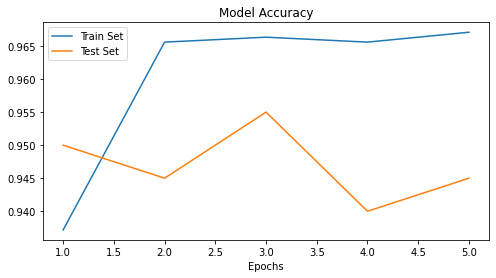

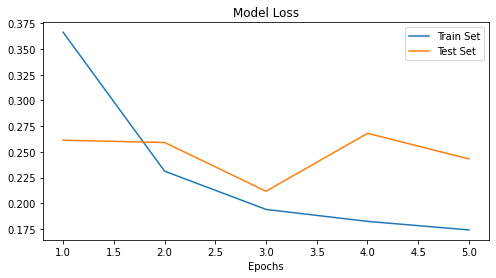

In [34]:
epochs = 5

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.show()

In [35]:
Y_pred = model.predict(test_datagen,test_steps+1)
y_pred = np.argmax(Y_pred,axis=1)

CM =confusion_matrix(test_datagen.classes,y_pred)
print("Confusion Matrix :")
print(CM)

pneumonia_precision= CM[1][1] / (CM[1][0]+CM[1][1])
print("pnuemonia_precision:", pneumonia_precision)

pnuemonia_recall = CM[1][1] / (CM[1][1]+CM[0][1])
print('pnuemonia_recall   :', pnuemonia_recall)

accuracy = (CM[0][0]+CM[1][1])/(CM[0][0]+CM[0][1]+CM[1][0]+CM[1][1])
print('Accuracy           :', accuracy)

target_names = ['Normal', 'COVID19'] 
print(classification_report(test_datagen.classes, y_pred, target_names=target_names))

Confusion Matrix :
[[  0  12]
 [  0 234]]
pnuemonia_precision: 1.0
pnuemonia_recall   : 0.9512195121951219
Accuracy           : 0.9512195121951219
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        12
     COVID19       0.95      1.00      0.97       234

    accuracy                           0.95       246
   macro avg       0.48      0.50      0.49       246
weighted avg       0.90      0.95      0.93       246



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
